# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', 22)
print(data.info())
print(data.head(20))
print(data.describe())
print(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

В датафрейме 23699 строк. Во многих столбцах есть пропущенные строки, надо понять откуда они появились и заполнить недостающие значения. В столбце is_apartment почти все значения пропущены, столбец имеет булев тип данных. Встречаются квартиры с потолками в 100 метров и в 1 метр. Все эти данных уберем на последующих этапах. 
Пропуски в ceiling_height можно заменить на средние по городу или по району в случае СПб

### Шаг 2. Предобработка данных

In [2]:
data['is_apartment'] = data['is_apartment'].fillna(False) #заменил NaN в столбце на False
data['balcony'] = data['balcony'].fillna(0) #заменил NaN в столбюце балконы на 0
data['floors_total'] = data['floors_total'].fillna(1) #заменил NaN в количестве этажей на 1
days_med = data['days_exposition'].median() #медианно значение days_exposition
data['days_exposition'] = data['days_exposition'].fillna(value=days_med)

Думаю, что пропуски в is_apartment означают, что квартира не является апартаментами, заменю все Nan на False.
Пропуски в balcony скорее всего означают, что у квартиры нет балкона, заменю все NaN на 0.
Пропуски в floors_total возможно означают, что дом одноэтажный. В датафрейме было 86 пропусков, такая замена должна не сильно исказить результаты. Пропуски в days_exposition заменил на медианные значения, т.к. других подходящих значений у нас нет.


In [3]:
data['is_apartment'] = data['is_apartment'].astype('bool') #заменил тип данных столбца is_apartment на булевый.
data['floors_total'] = data['floors_total'].astype('int')  #змаенил тип данных столбца floors_total на целые числа
data['balcony'] = data['balcony'].astype('int') #заменил тип данных столбца balcony на целые числа
data['days_exposition'] = data['days_exposition'].astype('int') #заменил тип данных столбца days_exposition на целые числа
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%d') #заменил тип данных столбца first_day_exposition на дату

Заменил тип данных в столбцах, которые этого требовали. is_aparment отоброжает два значения True False - у этого столбца должен быть булевый тип данных. 
floors_total, balcony, days_exposition указаны как вещественные, перевел их в целые, т.к. эти числа не могут быть дробными.
first_day_exposition заменил на дату, убрал часы и минуты, т.к. там стояли нули и все равно нам эта информация не понадобится.

In [4]:
print(data['locality_name'].value_counts()) #смотрю кол-во уникальных населенных пунктов

Санкт-Петербург                                            15721
посёлок Мурино                                               522
посёлок Шушары                                               440
Всеволожск                                                   398
Пушкин                                                       369
                                                           ...  
садоводческое некоммерческое товарищество Лесная Поляна        1
деревня Вахнова Кара                                           1
посёлок Форт Красная Горка                                     1
деревня Иссад                                                  1
поселок городского типа Кондратьево                            1
Name: locality_name, Length: 364, dtype: int64


В датафрейме 364 уникальных записи населенных пунктов. Невооруженным глазом видно, что встречаются дублирующие записи типа - Кудрово-деревня Кудрово, Мурино-деревня Мурино. Иногда пишут "поселок, иногда "посёлок".

In [5]:
locations = data['locality_name'].unique() #создал список со всеми названиями населенных пунктов
locations

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [6]:
def new_locality_name(value): #функция чтобы убрать дубликаты
    if str(value) == 'nan':
        return
    
    locations = ['Мурино', 'Кудрово']
    words = value.split(' ')
    
    if words[0] == 'поселок':
        words[0] = 'посёлок'
    
    for locality in locations:
        if locality in words:
            return locality
        
    return ' '.join(words)

In [7]:
data['locality_name'] = data['locality_name'].apply(new_locality_name)
print(data['locality_name'].sort_values().unique())

['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской поселок Большая Ижора'
 'городской поселок Янино-1' 'городской посёлок Будогощь'
 'городской посёлок Виллози' 'городской посёлок Лесогорский'
 'городской посёлок Мга' 'городской посёлок Назия'
 'городской посёлок Новоселье' 'городской посёлок Павлово'
 'городской посёлок Рощино' 'городской посёлок Свирьстрой'
 'городской посёлок Советский' 'городской посёлок Фёдоровское'
 'городской посёлок Янино-1' 'деревня Агалатово' 'деревня Аро'
 'деревня Батово' 'деревня Бегуницы' 'деревн

Изменил названия деревня Кудрово, деревня Мурино на Кудрово и Мурино. Заменил поселок на посёлок. Теперь получилось 329 населенных пункта.

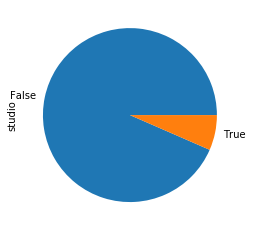

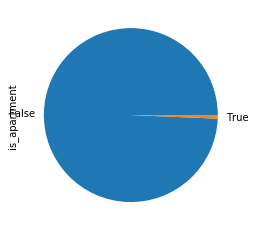

9.1


In [8]:
non_kitchen_area = data[data['kitchen_area'].isnull()] #датафрейм с отсутствующими данными в kitchen_area

non_kitchen_area['studio'].value_counts().plot(kind='pie')
plt.show()

non_kitchen_area['is_apartment'].value_counts().plot(kind='pie')
plt.show()
print(data['kitchen_area'].median())


Предположил, что пропуски в kitchen_area появлись из-за студий или апартаментов. Для студий обычно не указывают площадь кухни. В апартаментах может быть не предусмотрено кухни в принципе.

На графике видно, что подавляющее большинство пропусков в kitchen_area не связаны с квартирами студиями или апартаментами.

Заменим пропуски медианой:

In [9]:
data.loc[data['kitchen_area'].isnull(), 'kitchen_area'] = data['kitchen_area'].median() #заменил пропуски на медианные значения.
print(data['kitchen_area'].isnull().sum())


0


Пропуски в locality_name. Предположу, что сможем заменить часть пропусков исходя из столбца cityCenters_nearest:

In [10]:
data[(data['locality_name'].isnull())][['locality_name', 'cityCenters_nearest']].head()

,locality_name,cityCenters_nearest
1097,None,4258.0
2033,None,NaN
2603,None,17369.0
2632,None,17369.0
3574,None,8127.0


У некоторых пропусков в locality_name есть данные в cityCenters_nearest. Там где расстояние до центра меньше 10км - может заменить на СПб

In [11]:
data.loc[(data['locality_name'].isnull()) & (data['cityCenters_nearest'] < 10000), 'locality_name'] = data.loc[(data['locality_name'].isnull()) & (data['cityCenters_nearest'] < 10000), 'locality_name'].fillna('Санкт-Петербург')
print(data['locality_name'].isnull().sum())

24


Заменил 25 пропусков в locality_name на СПб, из расчёта, что в строках с пропусками были данные столбца cityCenters_nearest меньше 10км.

остальные пропуски в cityCenters_nearest и airports_nearest можно заменить медианными значениями по каждому населенному пункту:

In [12]:
median_nearest = data.pivot_table(index='locality_name', values=['cityCenters_nearest','airports_nearest'], aggfunc='median')
#сводная таблица по городам и медианному расстоянию до центра и аэропорта
median_nearest

,airports_nearest,cityCenters_nearest
locality_name,,
Зеленогорск,72282.0,53381.0
Колпино,26232.0,32018.0
Красное Село,25715.5,29140.5
Кронштадт,67850.0,49575.0
Ломоносов,48415.5,51677.0
Мурино,51553.0,21888.0
Павловск,20529.5,32683.0
Петергоф,39231.0,33771.0
Пушкин,15766.0,27930.5


In [13]:
median_data_locations = list(median_nearest.index) #функция для замены пропусков в cityCenters_nearest и airports_nearest
def fill_non_nearest(row, col):
    locality = row['locality_name']
    
    if locality in median_data_locations:
        return median_nearest.loc[locality][col]
    
    return row[col]
columns = ['cityCenters_nearest', 'airports_nearest']

for column in columns:
    data.loc[data[column].isnull(), column] = data.apply(fill_non_nearest, axis=1, args=(column,))

In [14]:
data['cityCenters_nearest'].isnull().sum()
data['airports_nearest'].isnull().sum()

4838

# Вывод


Заменил пропуски в тех столбцах, в которых это было возможно. Для остальных пропусков нет подходящей замены. Оставим их так как есть.

### Шаг 3. Посчитайте и добавьте в таблицу

Добавляем столбец с ценой за квадратный метр:

In [15]:
data['price_for_metr'] = data['last_price'] / data['total_area']


Добавляем столбец с днём недели месяцем и годом публикации:

In [16]:
data['weekday_of_exposition'] = data['first_day_exposition'].dt.weekday
data['month_of_exposition'] = data['first_day_exposition'].dt.month
data['year_of_exposition'] = data['first_day_exposition'].dt.year

Добавляем столбец с типом этажа квартиры:

In [17]:
def type_of_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data.loc[:, 'type_of_floor'] = data.apply(type_of_floor, axis=1)

Добавляем столбец с соотношением жилой и общей площади, а также отношением площади кухни к общей.

In [18]:
data['living_to_total'] = data['living_area'] / data['total_area']
data['kitchen_to_total'] = data['kitchen_area'] / data['total_area']

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Проверяем площадь:

In [19]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

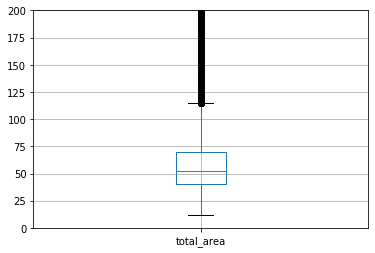

In [20]:
plt.ylim(0, 200)
data.boxplot('total_area')
plt.show()

Большая часть значений лежит в диапазоне до 70 кв.м.
Первый квартиль находится на уровне 40 кв.м.
Нижний ус упирается в 15, минимальное значение.
Верхний ус заканчивается на 115 кв.м.
Все, что лежит за ориентировочной границей нормального - считаем выбросом.

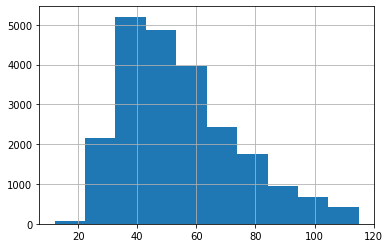

In [21]:
data.query('total_area >= 12 and total_area <= 115')['total_area'].hist()
plt.show()

Проверяем цену:

In [22]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

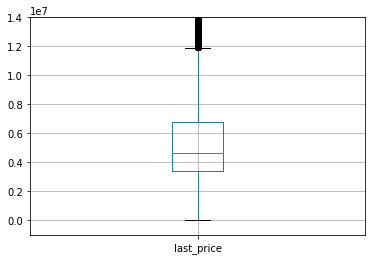

In [23]:
plt.ylim(-1e+06, 1.4e+07)
data.boxplot('last_price')
plt.show()

Большая часть значений лежит в диапазоне до 7 млн.
Первый квартиль на уровне 3.4 млн.
Нижний ус упирается в 0. Минимум равен 12190. Средняя стоимость – 6.5 млн. Выгдлядит странно. Проверим на срезе:

In [24]:
cheap_data = data.query('last_price < 4.5e+5')
cheap_data.sort_values('last_price').head()[['locality_name', 'last_price', 'total_area']]

,locality_name,last_price,total_area
8793,Санкт-Петербург,12190.0,109.0
14911,посёлок станции Свирь,430000.0,54.0
17456,Сланцы,430000.0,30.4
16274,деревня Старополье,440000.0,40.0


Цена 12190 за квартру 109 кв.м. это явная ошибка в данных.
Построим гистрограмму по цене от нижнего уса в 430к до верхнего.

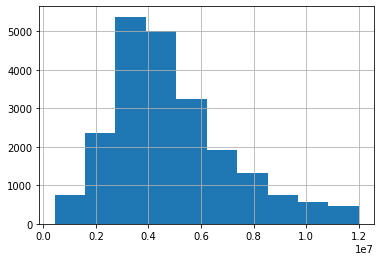

In [25]:
data.query('last_price >= 4.3e+5 and last_price <= 1.2e+7')['last_price'].hist()
plt.show()

Проверяем число комнат:

In [26]:
data['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

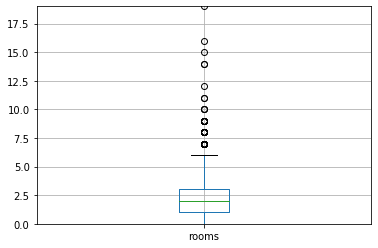

In [27]:
plt.ylim(0, 19)
data.boxplot('rooms')
plt.show()

Большая часть значений лежит в диапазоне до 3х комнат.
Первый квартиль находится на уровне 1 комнаты.
Нижний ус упирается в 0 - минимальное значение. Это ошибка в данных.
Верхний ус заканчивается около 6.
Выбросы лежат за ориентировочной границей нормального распределения.

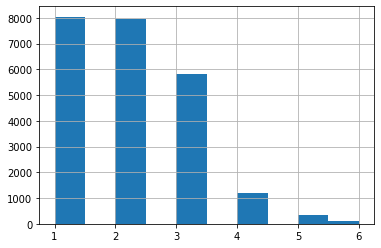

In [28]:
data.query('rooms >= 1 and rooms <= 6')['rooms'].hist()
plt.show()

Проверяем потолки:

In [29]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

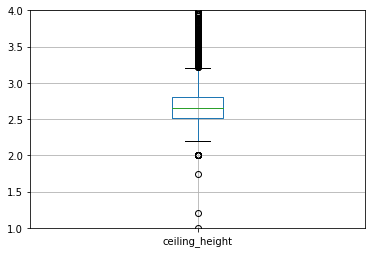

In [30]:
plt.ylim(1,4)
data.boxplot('ceiling_height')
plt.show

Большая часть значений лежит в диапазоне до 2.8 метров
Первый квартиль находится на уровне 2.5 метра
Нижний ус упирается в 2.2 метра
Верхний ус заканчивается около 3.2 метра

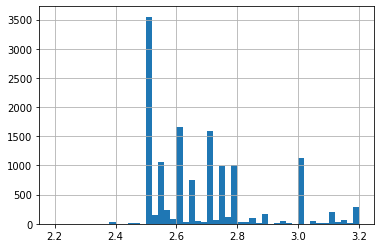

In [31]:
data.query('ceiling_height >= 2.2 and ceiling_height <= 3.2')['ceiling_height'].hist(bins=50)
plt.show()

Проверяем время продажи:

In [32]:
data['days_exposition'].describe()

count    23699.000000
mean       169.360226
std        206.535633
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

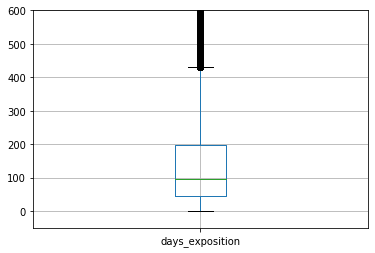

In [33]:
plt.ylim(-50,600)
data.boxplot('days_exposition')
plt.show

Большая часть значений лежит в диапазоне до 200 дней.
Первый квартиль лежит на уровне 45 дней.
Нижний ус упирается в 1 - минимальное значение
Верхний заканчивается в около 425 дней.
Вывод:
Продажа занимает около 100 дней;
Если квартирау продали в течение 50 дней – это очень быстро.
Если в диапазоне от 200 дней – очень долго.

<function matplotlib.pyplot.show(*args, **kw)>

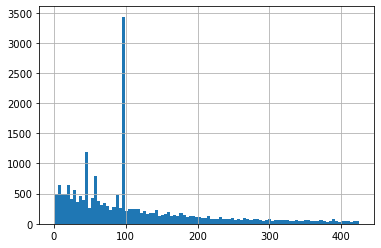

In [34]:
data.query('days_exposition >= 1 and days_exposition <= 425')['days_exposition'].hist(bins=100)
plt.show

### Посмотрим факторы, влияющие на стоимость квартиры:

Для анализы будем исользовать срезы, полученные выше. Создадим новый датафрейм по срезу:

In [35]:
good_data = data.query('12 <= total_area <= 115 and 4.3e+5 <= last_price <= 1.2e+7 and 1 <= rooms <= 6 and 2.2 <= ceiling_height <= 3.2 and  1 <= days_exposition <= 425')



Посторим график зависимость цены от квадратного метра:

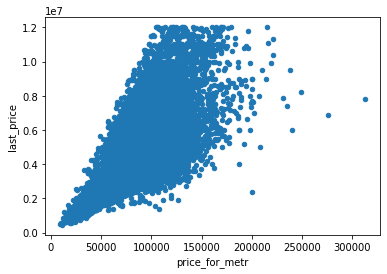

In [36]:
good_data.plot(x='price_for_metr', y='last_price', kind='scatter')
plt.show()

Посчитаем корреляцию:

In [37]:
good_data['price_for_metr'].corr(good_data['last_price'])

0.6281399892076448

На графике видно, что есть сильная корреляция между ценой за метр и стоимостью квартиры.

Посмотрим график зависимости цены от количества комнат:

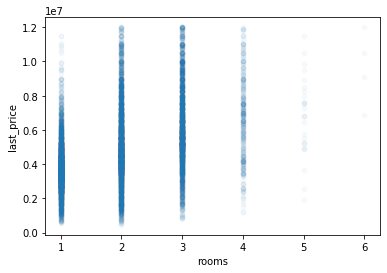

In [38]:
good_data.plot(x='rooms', y='last_price', kind='scatter', alpha=0.03)
plt.show()

Посчитаем корреляцию:

In [39]:
good_data['rooms'].corr(good_data['last_price'])

0.4270974810456912

На графике видно, что корреляция между количеством комнат и стоимостью квартиры слабая.

Посмотрим график зависимости цены от удаленности от центра:

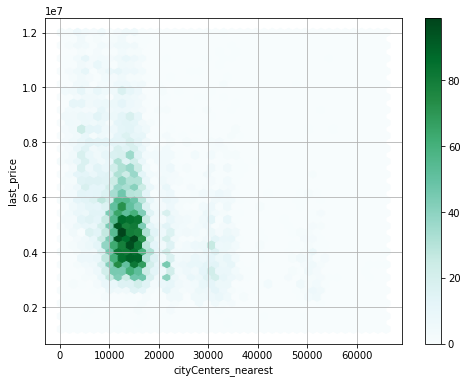

In [40]:
good_data.plot(x='cityCenters_nearest', y='last_price', kind='hexbin', gridsize=40, figsize=(8, 6), sharex=False, grid=True)
plt.show()

Посчитаем корреляцию:

In [41]:
good_data['cityCenters_nearest'].corr(good_data['last_price'])

-0.32445496741491886

Корреляция между расстоянием до центра и ценой довольно слабая. 

Посмотрим таблицу зависимости цены от этажа:

In [42]:
print(good_data.pivot_table(index='type_of_floor', values='last_price'))

                 last_price
type_of_floor              
другой         5.087566e+06
первый         4.243161e+06
последний      4.593457e+06


Первый этаж самый дешевый, затем последний и самый дорогие это средние этажи. 
"Первый, последний не предлагать" В.Цой

Посмотрим таблицу зависимости цены от даты публикации объявления:

In [43]:
good_data[['weekday_of_exposition', 'month_of_exposition', 'year_of_exposition', 'last_price']].corr()

,weekday_of_exposition,month_of_exposition,year_of_exposition,last_price
weekday_of_exposition,1.000000,-0.010836,-0.010530,-0.022974
month_of_exposition,-0.010836,1.000000,-0.357262,0.000657
year_of_exposition,-0.010530,-0.357262,1.000000,0.034074
last_price,-0.022974,0.000657,0.034074,1.000000


Cвязи между днем недели, месяцем, годом и ценой практически нет. В таблице видна некоторая корреляция между годом и месяцем, видимо в какие-то месяца год из года публиуется больше объявлений.

Выберем 10 населенных пунктов с наибольшим числом объявлений.

In [44]:
top10=good_data['locality_name'].value_counts().head(10)
top10

Санкт-Петербург      7544
Всеволожск            233
Мурино                198
посёлок Шушары        195
Колпино               186
Пушкин                182
Кудрово               167
Гатчина               130
посёлок Парголово     129
Петергоф              118
Name: locality_name, dtype: int64

Средняя цена квадратного метра в топ10 населенных пунктов:

In [45]:
top10_names=list(top10.index)

In [46]:
good_data.query('locality_name in @top10_names').pivot_table(index='locality_name', values='price_for_metr').sort_values('price_for_metr', ascending=False)


,price_for_metr
locality_name,
Санкт-Петербург,106309.435737
Пушкин,100302.532095
Кудрово,96137.956629
посёлок Парголово,90479.114570
Мурино,88360.817355
Петергоф,84320.929979
посёлок Шушары,79891.865944
Колпино,75647.819910
Гатчина,70330.187130


Самая высокая стоимость за квадрат в СПб, самая низкая во Всеволожске. Ожидаемо.

Посмотрим среднюю цену для каждого километра:

In [47]:
spb = pd.DataFrame(data.loc[data['locality_name'] == "Санкт-Петербург"]) #Все квартиры в спб
spb.reset_index()
len(spb)

15746

In [48]:
spb['cityCenters_nearest_km'] = (spb['cityCenters_nearest'] / 1000).astype('int') #создал столбец с растоянием до центра в км


Посмотрим цену на каждом километре от цетнра СПб:

In [49]:
spb_prices = spb.query('last_price >= 4.3e+5 and last_price <= 1.2e+7')
spb_prices_pivot=spb_prices.pivot_table(index='cityCenters_nearest_km', values='last_price')
spb_prices_pivot

,last_price
cityCenters_nearest_km,
0,8.429409e+06
1,8.420789e+06
2,7.721342e+06
3,7.595840e+06
4,7.849506e+06
5,7.442350e+06
6,6.887989e+06
7,6.765614e+06
8,6.343466e+06


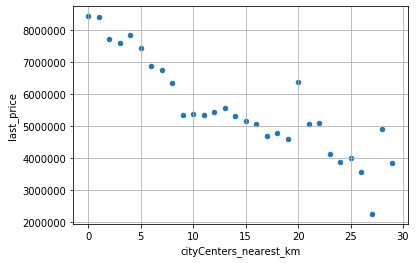

In [50]:
(
    pd.DataFrame(spb_prices.pivot_table(index='cityCenters_nearest_km', values='last_price').to_records())
    .plot(x='cityCenters_nearest_km', y='last_price', kind='scatter', grid=True)
)
plt.show()

Цена резко падает в районе 7км от центра.

In [51]:
center_flats = pd.DataFrame(spb_prices.query('cityCenters_nearest_km <= 7')) #все квартиры в Спб в радиусе 7км от цетнра
len(center_flats)

2516

Посмотрим на статистику этих квартир:

In [52]:
center_flats['total_area'].describe()

count    2516.000000
mean       67.448470
std        24.921507
min        12.000000
25%        48.000000
50%        64.500000
75%        82.125000
max       206.000000
Name: total_area, dtype: float64

In [53]:
center_flats['last_price'].describe()

count    2.516000e+03
mean     7.502598e+06
std      2.262105e+06
min      1.600000e+06
25%      5.800000e+06
50%      7.400000e+06
75%      9.150000e+06
max      1.200000e+07
Name: last_price, dtype: float64

In [54]:
center_flats['rooms'].describe()

count    2516.000000
mean        2.366057
std         1.055867
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: rooms, dtype: float64

In [55]:
center_flats['ceiling_height'].describe()

count    1611.000000
mean        3.046108
std         0.999466
min         2.400000
25%         2.750000
50%         3.000000
75%         3.200000
max        32.000000
Name: ceiling_height, dtype: float64

Посмотрим на факторы влияющие на стоимость:

In [56]:
new_data = center_flats.query('12 <= total_area <= 115 and 4.3e+5 <= last_price <= 1.2e+7 and 1 <= rooms <= 6 and 2.2 <= ceiling_height <= 3.2 and  1 <= days_exposition <= 425')
#добавляю в срез центральных квартир условия из good_data

In [57]:
new_data = new_data.reindex(columns=['last_price', #смотрим корреляцию по всем факторам
    'cityCenters_nearest_km',
    'total_area',
    'rooms',
    'ceiling_height',
    'weekday_of_exposition',
    'month_of_exposition',
    'year_of_exposition'])
new_data.corr().sort_values('last_price', ascending=False)


,last_price,cityCenters_nearest_km,total_area,rooms,ceiling_height,weekday_of_exposition,month_of_exposition,year_of_exposition
last_price,1.000000,-0.195269,0.694978,0.474002,0.245136,-0.039490,-0.005199,0.021725
total_area,0.694978,-0.221132,1.000000,0.805171,0.307588,-0.066417,0.020211,-0.073373
rooms,0.474002,-0.196226,0.805171,1.000000,0.234014,-0.051503,0.023315,-0.031461
ceiling_height,0.245136,-0.282868,0.307588,0.234014,1.000000,-0.029623,-0.060611,-0.029045
year_of_exposition,0.021725,0.076234,-0.073373,-0.031461,-0.029045,0.056563,-0.367061,1.000000
month_of_exposition,-0.005199,-0.034559,0.020211,0.023315,-0.060611,0.019164,1.000000,-0.367061
weekday_of_exposition,-0.039490,0.039018,-0.066417,-0.051503,-0.029623,1.000000,0.019164,0.056563
cityCenters_nearest_km,-0.195269,1.000000,-0.221132,-0.196226,-0.282868,0.039018,-0.034559,0.076234


In [58]:
new_data['type_of_floor']=data['type_of_floor'] #добавил в новый датафрейм с данными по центру столбец с типом этажа
new_data.pivot_table(index='type_of_floor', values='last_price').sort_values(by='last_price')

,last_price
type_of_floor,
первый,6.358507e+06
последний,7.349132e+06
другой,7.369361e+06


В целом на стоиомсть квартиры в центре влияют теже факторы с такой же корреляцией, что и на остальной территории.

### Шаг 5. Общий вывод

Городом с самыми дорогими квартирами оказался Санкт-Петербург. В центре СПб самые дорогие кваритры из всей территории.
На стоимость главным образом влияют следующие факторы:  площадь, количество комнат и высота потолков.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [ ]  файлы изучены (выведены первые строки, метод info())
- [ ]  определены пропущенные значения
- [ ]  заполнены пропущенные значения
- [ ]  есть пояснение, какие пропущенные значения обнаружены
- [ ]  изменены типы данных
- [ ]  есть пояснение, в каких столбцах изменены типы и почему
- [ ]  посчитано и добавлено в таблицу: цена квадратного метра
- [ ]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [ ]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [ ]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [ ]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [ ]  построены гистограммы для каждого параметра
- [ ]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [ ]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [ ]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [ ]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [ ]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [ ]  в каждом этапе есть выводы
- [ ]  есть общий вывод